In [1]:
from pathlib import Path

import pyarrow.dataset as ds
import pyarrow as pa
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression

from lib.aggregate.cell_data_utils import DEFAULT_METADATA_COLS
from lib.aggregate.align import prepare_alignment_data, centerscale_on_controls
from lib.aggregate.cell_data_utils import load_metadata_cols, split_cell_data

2025-05-09 10:28:57.069874: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
filtered_data_dir = Path("/lab/cheeseman_ops/brieflow-screens/denali-analysis/analysis/analysis_root/aggregate/parquets")
filtered_data_paths = list(filtered_data_dir.glob("*_CeCl-Interphase_ChCo-DAPI_COXIV_CENPA_WGA__filtered.parquet"))[:10]

filtered_data_paths

[PosixPath('/lab/cheeseman_ops/brieflow-screens/denali-analysis/analysis/analysis_root/aggregate/parquets/P-3_W-A3_CeCl-Interphase_ChCo-DAPI_COXIV_CENPA_WGA__filtered.parquet'),
 PosixPath('/lab/cheeseman_ops/brieflow-screens/denali-analysis/analysis/analysis_root/aggregate/parquets/P-3_W-B3_CeCl-Interphase_ChCo-DAPI_COXIV_CENPA_WGA__filtered.parquet'),
 PosixPath('/lab/cheeseman_ops/brieflow-screens/denali-analysis/analysis/analysis_root/aggregate/parquets/P-2_W-B1_CeCl-Interphase_ChCo-DAPI_COXIV_CENPA_WGA__filtered.parquet'),
 PosixPath('/lab/cheeseman_ops/brieflow-screens/denali-analysis/analysis/analysis_root/aggregate/parquets/P-1_W-A2_CeCl-Interphase_ChCo-DAPI_COXIV_CENPA_WGA__filtered.parquet'),
 PosixPath('/lab/cheeseman_ops/brieflow-screens/denali-analysis/analysis/analysis_root/aggregate/parquets/P-1_W-A1_CeCl-Interphase_ChCo-DAPI_COXIV_CENPA_WGA__filtered.parquet'),
 PosixPath('/lab/cheeseman_ops/brieflow-screens/denali-analysis/analysis/analysis_root/aggregate/parquets/P-3_

In [3]:
GENE = "RPL17" # high perturbation score example
# GENE = "EFNB3" # low perturbation score example

filtered_dataset = ds.dataset(filtered_data_paths, format="parquet")
perturbation_col = filtered_dataset.to_table(columns=["gene_symbol_0"]).to_pandas()["gene_symbol_0"]

gene_indices = perturbation_col.str.contains(GENE, na=False).to_numpy().nonzero()[0]
nontargeting_indices = perturbation_col.str.contains("nontargeting", na=False).to_numpy().nonzero()[0]
nontargeting_indices = np.random.choice(nontargeting_indices, size=len(gene_indices), replace=False)
combined_indices = np.union1d(gene_indices, nontargeting_indices)

subset_df = filtered_dataset.scanner().take(pa.array(combined_indices))
subset_df = subset_df.to_pandas(use_threads=True, memory_pool=None).reset_index(drop=True)

metadata_cols = DEFAULT_METADATA_COLS + ["class", "confidence"]
feature_cols = subset_df.columns.difference(metadata_cols, sort=False)

metadata, features = split_cell_data(subset_df, metadata_cols)
metadata, features = prepare_alignment_data(
    metadata,
    features,
    ["plate", "well"],
    "gene_symbol_0",
    "nontargeting",
    "sgRNA_0",
)
features = features.astype(np.float32)

features = centerscale_on_controls(
    features,
    metadata,
    "gene_symbol_0",
    "nontargeting",
    "batch_values",
)
features = pd.DataFrame(features, columns=feature_cols)

subset_df_scaled = pd.concat([metadata, features], axis=1)

In [4]:
def get_top_differential_features(cell_data, feature_cols, gene, n_features=100):
    """Get top differentially expressed features between control and gene using t-test"""
    results = []

    control_cells = cell_data[cell_data["gene_symbol_0"].str.startswith("nontargeting")]
    gene_cells = cell_data[cell_data["gene_symbol_0"] == gene]

    for feature in feature_cols:
        if feature not in control_cells.columns or feature not in gene_cells.columns:
            continue

        control_values = control_cells[feature].dropna()
        gene_values = gene_cells[feature].dropna()

        if len(control_values) < 2 or len(gene_values) < 2:
            continue

        t_stat, p_value = stats.ttest_ind(control_values, gene_values, equal_var=False)

        results.append({
            'feature': feature,
            'pvalue': p_value,
            'control_mean': control_values.mean(),
            'gene_mean': gene_values.mean()
        })

    results_df = pd.DataFrame(results).sort_values('pvalue')
    return results_df.head(n_features)['feature'].tolist()

diff_exp_features = get_top_differential_features(
    subset_df_scaled,
    feature_cols,
    GENE,
    n_features=200,
)

## Derive Perturbation Score

We aim to implement a modified version of the perturbation score methodology from [Li et al., 2025](https://www.nature.com/articles/s41556-025-01626-9) on our phenotypic features.
Our implementation is:
1) Identify top n differential features with a two‑sample t‑test (perturbation vs. nontargeting controls).
2) Compute the perturbation signature β = mean(feature values in gene‑perturbed cells) − mean(feature values in controls) for those features.
3) Project and scale:
    - Project every cell onto β to obtain a scalar score.
    - Fit a 1‑D linear model to map this projection onto the binary gene label, then rescale the prediction to the [0, 1] interval to yield the final perturbation score.

In [5]:
def get_perturbation_score(cell_data, gene, diff_exp_features):
    """Compute perturbation scores for a given gene using a projection-based method."""

    feature_data = cell_data[diff_exp_features]
    gene_mask = cell_data["gene_symbol_0"] == gene
    control_mask = cell_data["gene_symbol_0"].str.startswith("nontargeting")

    gene_features = feature_data[gene_mask]
    control_features = feature_data[control_mask]

    # Compute signature vector (beta)
    beta = (gene_features.mean() - control_features.mean()).to_numpy()
    norm_squared = beta @ beta

    # Project all cells onto the signature
    projection = (feature_data @ beta) / norm_squared

    # Fit linear model to binary label
    binary_labels = gene_mask.astype(int)
    lin_model = LinearRegression().fit(projection.values.reshape(-1, 1), binary_labels)
    raw_scores = lin_model.predict(projection.values.reshape(-1, 1))

    # Scale scores to [0, 1]
    scaled_scores = (raw_scores - raw_scores.min()) / (raw_scores.max() - raw_scores.min())
    return scaled_scores

perturbation_scores = get_perturbation_score(subset_df_scaled, GENE, diff_exp_features)
subset_df_scaled["perturbation_score"] = perturbation_scores
subset_df_scaled

,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,cell_percent_touching_1,cell_first_neighbor_distance,cell_second_neighbor_distance,cell_angle_between_neighbors,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors,perturbation_score
0,3,A3,1529,729,1491.643402,1456.232279,366,2514,673.406250,663.656250,...,1.118296,-1.421546,-1.185348,-0.337457,1.297320,1.249702,-1.324297,-1.300522,-0.462502,0.717792
1,3,A3,69,437,1471.200000,1419.056198,12,230,99.068966,652.982759,...,2.179747,-1.845203,-1.266400,-0.399346,3.144590,2.531582,-1.459490,-1.278983,-0.406236,0.498188
2,3,A3,69,450,1505.649180,1410.947541,12,250,107.672727,650.727273,...,1.685833,-1.845203,-0.936338,1.666058,1.297320,1.893542,-1.459490,-1.314654,1.652801,0.586296
3,3,A3,1305,565,1586.263158,1505.184211,319,1880,698.014493,675.565217,...,-0.465086,0.866681,0.174353,-1.165142,-0.549951,-0.467204,1.051886,0.129501,-1.111766,0.504226
4,3,A3,1258,557,1592.487677,1462.127707,302,2024,698.448276,664.655172,...,-0.465086,-0.542236,-0.298587,-1.164205,-0.549951,-0.467204,-0.251880,-0.450957,0.608931,0.516487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4941,2,A1,237,109,325.136998,136.169811,51,2546,964.039474,347.052632,...,-0.583945,1.118322,0.562836,-0.864226,-0.646850,-0.578634,0.795181,0.619063,-0.875430,0.749440
4942,2,A1,924,110,351.231135,102.852481,216,2446,974.059406,893.029703,...,-0.583945,-0.192259,-0.893555,-1.781993,-0.646850,-0.578634,-0.391680,-0.919364,-1.642622,0.426297
4943,2,A1,922,93,281.185115,125.032443,217,2584,958.266667,897.841667,...,-0.583945,0.867933,0.432135,-0.987918,-0.646850,-0.578634,0.655067,0.538361,-0.855331,0.346033
4944,2,A1,1291,38,126.361011,201.061372,287,2132,894.905660,909.075472,...,1.303632,-1.066902,-1.426516,-1.124858,1.722019,1.460454,-1.111214,-1.478208,-1.019749,0.445951


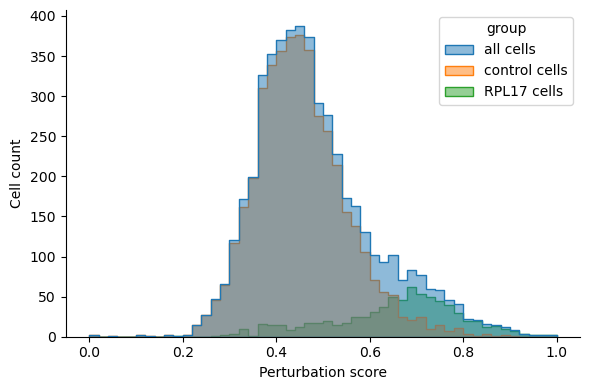

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plot_df = pd.concat([
    subset_df_scaled.assign(group="all cells"),
    subset_df_scaled[subset_df_scaled["gene_symbol_0"] != GENE].assign(group="control cells"),
    subset_df_scaled[subset_df_scaled["gene_symbol_0"] == GENE].assign(group=f"{GENE} cells"),
])

plt.figure(figsize=(6, 4))
sns.histplot(
    data=plot_df,
    x="perturbation_score",
    hue="group",
    bins=50,
    element="step",
    fill=True,
    stat="count",
    common_norm=False,
    alpha=0.5,
)
plt.xlabel("Perturbation score")
plt.ylabel("Cell count")
sns.despine()
plt.tight_layout()
plt.show()

/lab/barcheese01/rkern/miniconda3/envs/brieflow_denali_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


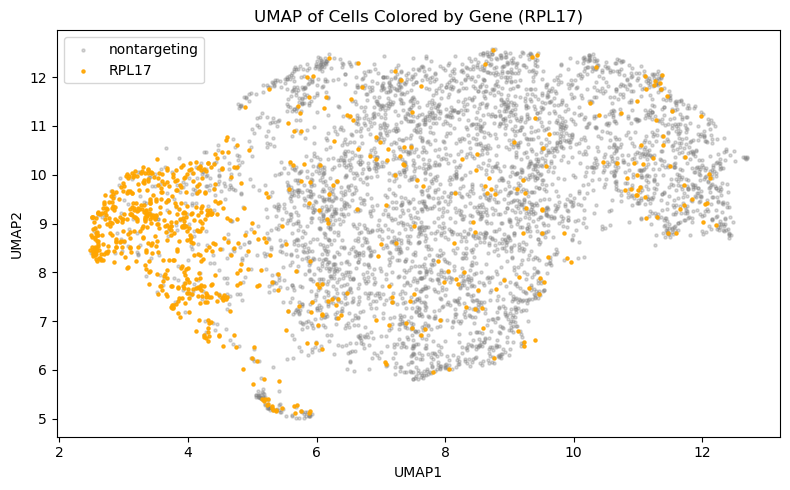

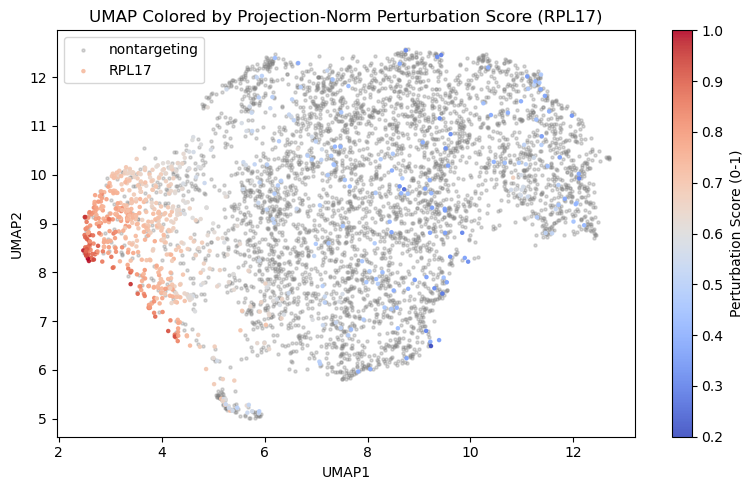

In [7]:
# Prepare data
X = subset_df_scaled[diff_exp_features]
control_X = subset_df_scaled[subset_df_scaled["gene_symbol_0"].str.startswith("nontargeting")][diff_exp_features]
is_gene = subset_df_scaled["gene_symbol_0"] == GENE

# UMAP
embedding = umap.UMAP(n_jobs=-1).fit_transform(X)

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(embedding[~is_gene, 0], embedding[~is_gene, 1], color="gray", s=5, alpha=0.3, label="nontargeting")
plt.scatter(embedding[is_gene, 0], embedding[is_gene, 1], color="orange", s=5, alpha=0.9, label=GENE)
plt.legend()
plt.title(f"UMAP of Cells Colored by Gene ({GENE})")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(embedding[~is_gene, 0], embedding[~is_gene, 1],
            c="gray", s=5, alpha=0.3, label="nontargeting")
plt.scatter(embedding[is_gene, 0], embedding[is_gene, 1],
            c=subset_df_scaled[is_gene]["perturbation_score"], cmap="coolwarm", s=5, alpha=0.9, label=GENE)
plt.legend()
plt.title(f"UMAP Colored by Projection-Norm Perturbation Score ({GENE})")
plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
plt.colorbar(label="Perturbation Score (0-1)")
plt.tight_layout()
plt.show()